## COVID-19 PAKISTAN Data Modeling

#### Packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
from pandas import read_excel
from scipy.optimize import minimize
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

COVID-19 Pakistan

#### Provincial Data Model

In [3]:
# Read  data file
full_table = pd.read_excel('F:/Data Sets/COVID-19/Pakistan/time series/COVID-19_DATA.xlsx',sheet_name='TimeSeries_KeyIndicators')
# Set Date into Pandas date format
full_table['Date'] = pd.to_datetime(full_table['Date'])
# Rename data frame columns
fulltable = full_table.rename(columns={"Cumulative  Test positive": "Confirmed", 
                                       "Expired": "Deaths","Discharged": "Recovered"})

In [4]:
# latest condensed
full_latest = fulltable[fulltable['Date'] == max(fulltable['Date'])].reset_index()
full_table_grouped = full_latest.groupby('Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [5]:
temp_f = full_table_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Region', 'Confirmed', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Oranges", subset=['Confirmed'])\
            .background_gradient(cmap="Blues", subset=['Recovered'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])


,Region,Confirmed,Deaths,Recovered
0,Punjab,5827,100,1427
1,Sindh,5291,92,963
2,KP,2160,114,562
3,Balochistan,915,14,176
4,GB,330,3,224
5,ICT,297,4,36
6,AJK,65,0,37


In [6]:
def get_time_series_province(province):
    df = fulltable[(fulltable['Region'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]

In [7]:
region = 'Punjab'
df = get_time_series_province(region)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered
Date,,,
2020-04-19,3721,42,702
2020-04-20,4195,45,742
2020-04-21,4328,51,742
2020-04-22,4590,58,790
2020-04-23,4767,65,905
2020-04-24,5046,73,1065
2020-04-25,5378,81,1126
2020-04-26,5446,83,1183
2020-04-27,5640,91,1306


# Model

I will use a model from a marketing paper by __Emmanuelle Le Nagard__ and __Alexandre Steyer__, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [61]:
import math

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [62]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    return math.sqrt(r) 

We need to explore the 3d parameter space to find a minimum, using __gradient descent__. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

## Build the Model

__Plot Model Fit__

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

def display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#999900FF', '#FF0000FF', '#0000FFFF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)


__Plot Extended Model Fit__

In [11]:
import datetime
import numpy as np
from scipy.optimize import minimize

def display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#999900FF', '#FF0000FF', '#0000FFFF']

    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)



__We are going to use Gradient Descent for Minimize Model Loss__

In [12]:
import datetime
import numpy as np
from scipy.optimize import minimize

def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([region, *opt_confirmed, *opt_deaths, *opt_recovered])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax2)
        plt.show()

### Pakistan National Count Prediction

Pakistan COVID-19 Prediction


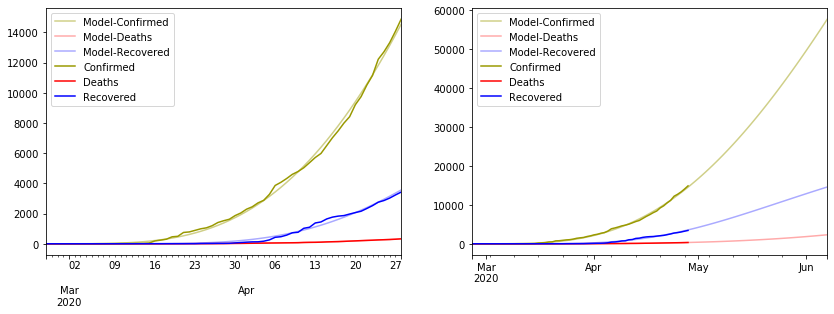

In [13]:
stats = []

df = fulltable[['Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']].groupby('Date').sum()
print('Pakistan COVID-19 Prediction')
opt_display_model(df, stats)

__Predictions Table__

In [20]:
import datetime
import numpy as np
from scipy.optimize import minimize

def display_extended_table_pr(df):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)    
                                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
    
    return extended_model_sim

In [63]:
# Display Predictions Table
df = fulltable[['Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']].groupby('Date').sum()
model = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, model], axis=1)
print('Pakistan COVID-19 Prediction')
concat_df[concat_df.index.day % 2 == 0].tail(21)


Pakistan COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-26,"13,328",281,"3,029","13,147",288,"3,150"
2020-04-28,"14,885",327,"3,425","14,552",330,"3,566"
2020-04-30,nan,nan,nan,"16,037",375,"4,005"
2020-05-02,nan,nan,nan,"17,602",425,"4,468"
2020-05-04,nan,nan,nan,"19,246",480,"4,951"
2020-05-06,nan,nan,nan,"20,968",540,"5,455"
2020-05-08,nan,nan,nan,"22,766",604,"5,975"
2020-05-10,nan,nan,nan,"24,640",674,"6,512"
2020-05-12,nan,nan,nan,"26,589",749,"7,062"
2020-05-14,nan,nan,nan,"28,609",830,"7,623"


### Predict By Provinces

AJK COVID-19 Prediction


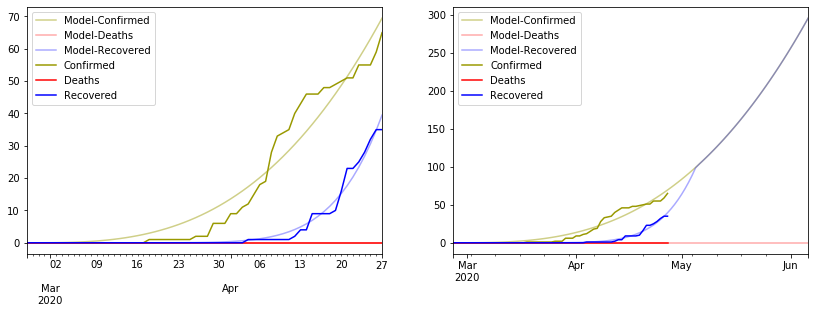

Balochistan COVID-19 Prediction


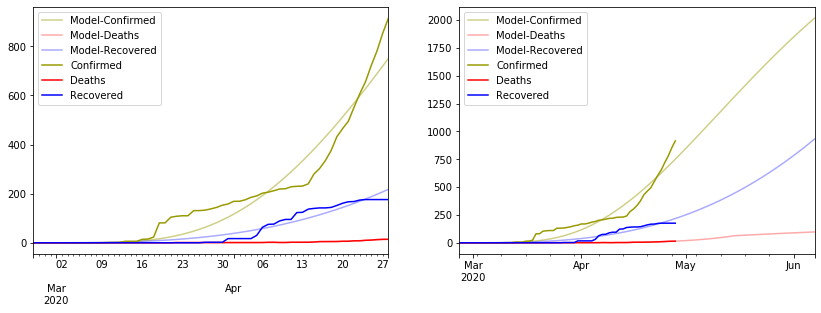

GB COVID-19 Prediction


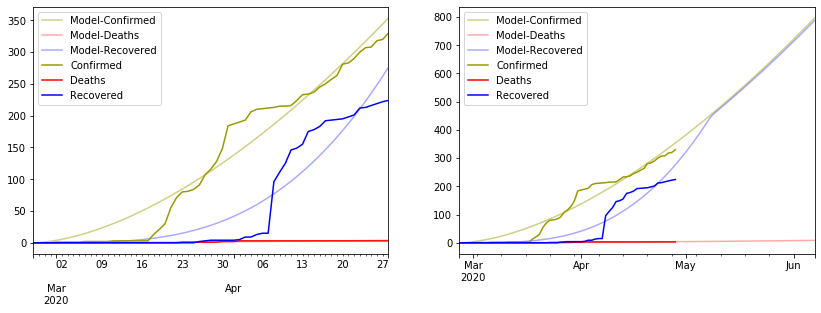

ICT COVID-19 Prediction


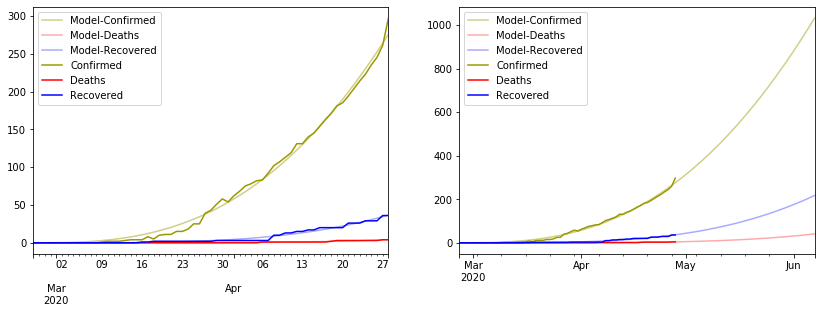

KP COVID-19 Prediction


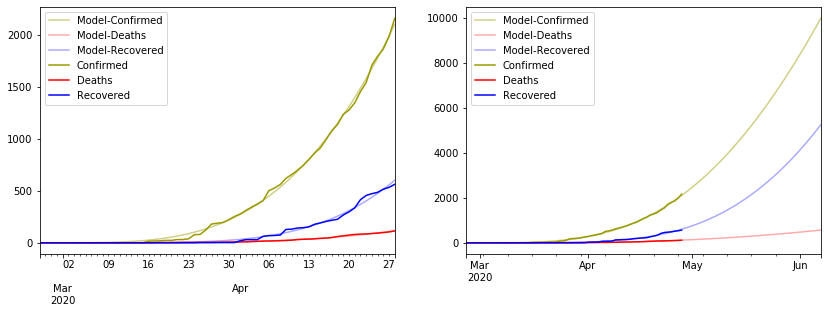

Punjab COVID-19 Prediction


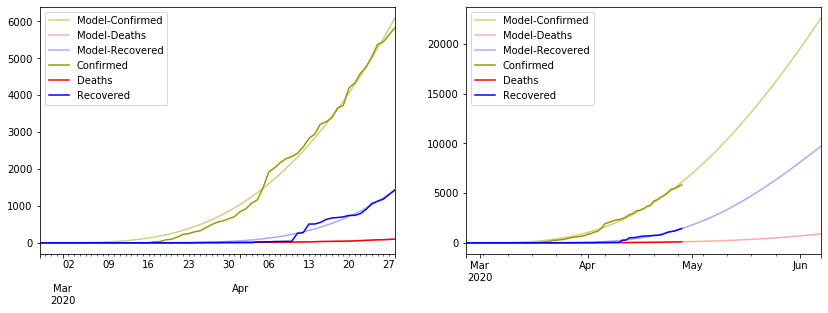

Sindh COVID-19 Prediction


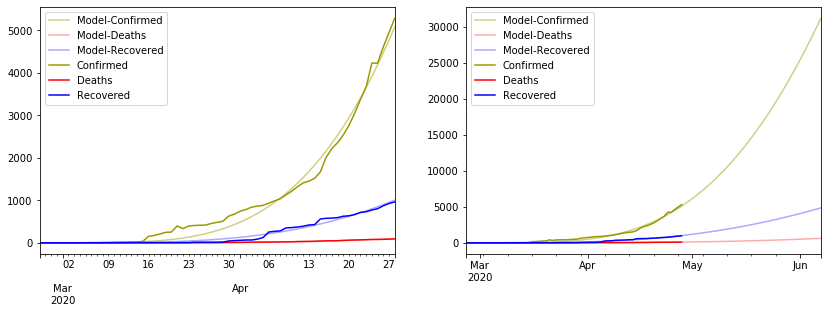

In [25]:
stats = []

# Province Specify
for region in ['AJK', 'Balochistan','GB','ICT','KP','Punjab','Sindh']:
    df = get_time_series_province(region)
    print('{} COVID-19 Prediction'.format(region))  
    opt_display_model(df, stats)

__Sindh__ 

In [26]:
df = get_time_series_province('Sindh')
print('{} COVID-19 Prediction'.format('Sindh')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Sindh COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"1,036",20,280,"1,052",21,254
2020-04-10,"1,214",22,358,"1,277",25,301
2020-04-12,"1,411",30,389,"1,535",30,353
2020-04-14,"1,518",35,427,"1,829",36,411
2020-04-16,"2,008",45,576,"2,160",42,476
2020-04-18,"2,355",48,592,"2,532",49,547
2020-04-20,"2,764",61,635,"2,947",56,624
2020-04-22,"3,373",69,715,"3,408",65,709
2020-04-24,"4,232",78,772,"3,916",75,800
2020-04-26,"4,615",81,872,"4,475",85,899


__Punjab__

In [27]:
df = get_time_series_province('Punjab')
print('{} COVID-19 Prediction'.format('Punjab')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Punjab COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"2,171",17,35,"1,869",16,171
2020-04-10,"2,336",19,39,"2,165",19,226
2020-04-12,"2,594",23,272,"2,487",24,294
2020-04-14,"2,945",28,508,"2,838",29,375
2020-04-16,"3,276",36,630,"3,216",35,471
2020-04-18,"3,649",41,684,"3,623",43,584
2020-04-20,"4,195",45,742,"4,058",51,714
2020-04-22,"4,590",58,790,"4,522",60,863
2020-04-24,"5,046",73,"1,065","5,016",71,"1,032"
2020-04-26,"5,446",83,"1,183","5,538",83,"1,221"


__AJK__

In [28]:
df = get_time_series_province('AJK')
print('{} COVID-19 Prediction'.format('AJK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

AJK COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,28,0,1,23,0,2
2020-04-10,34,0,1,27,0,3
2020-04-12,40,0,2,30,0,4
2020-04-14,46,0,4,34,0,6
2020-04-16,46,0,9,39,0,8
2020-04-18,48,0,9,44,0,11
2020-04-20,50,0,16,49,0,15
2020-04-22,51,0,23,54,0,20
2020-04-24,55,0,28,60,0,27
2020-04-26,59,0,35,66,0,35


__Balochistan__

In [29]:
df = get_time_series_province('Balochistan')
print('{} COVID-19 Prediction'.format('Balochistan')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Balochistan COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,212,2,76,228,1,67
2020-04-10,220,1,95,268,2,77
2020-04-12,230,2,123,311,2,89
2020-04-14,240,2,137,357,3,101
2020-04-16,303,5,142,406,4,114
2020-04-18,376,5,144,458,5,128
2020-04-20,465,6,161,512,6,144
2020-04-22,552,8,168,569,8,161
2020-04-24,656,10,176,628,10,178
2020-04-26,781,13,176,689,12,197


__Islamabad__

In [30]:
df = get_time_series_province('ICT')
print('{} COVID-19 Prediction'.format('Islamabad')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Islamabad COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,102,1,10,96,1,9
2020-04-10,113,1,13,109,1,10
2020-04-12,131,1,15,123,1,12
2020-04-14,140,1,17,138,1,14
2020-04-16,154,1,20,154,2,17
2020-04-18,171,2,20,171,2,19
2020-04-20,185,3,20,190,2,22
2020-04-22,204,3,26,209,3,25
2020-04-24,223,3,29,230,3,29
2020-04-26,245,3,29,252,4,33


__KPK__

In [31]:
df = get_time_series_province('KP')
print('{} COVID-19 Prediction'.format('KPK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

KPK COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,560,20,74,535,22,86
2020-04-10,656,25,131,633,27,110
2020-04-12,744,34,145,743,33,138
2020-04-14,862,38,178,865,40,172
2020-04-16,993,45,205,"1,000",47,211
2020-04-18,"1,137",60,226,"1,148",56,256
2020-04-20,"1,276",74,297,"1,310",66,309
2020-04-22,"1,453",83,414,"1,485",77,369
2020-04-24,"1,708",89,472,"1,676",89,437
2020-04-26,"1,864",98,515,"1,881",102,515


__GB__

In [32]:
df = get_time_series_province('GB')
print('{} COVID-19 Prediction'.format('Gigit-Baltistan')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Gigit-Baltistan COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,213,3,96,186,2,77
2020-04-10,215,3,125,201,2,90
2020-04-12,224,3,149,217,2,104
2020-04-14,234,3,175,232,3,120
2020-04-16,245,3,183,248,3,137
2020-04-18,257,3,193,265,3,156
2020-04-20,281,3,195,282,3,177
2020-04-22,290,3,201,299,3,199
2020-04-24,307,3,213,317,3,223
2020-04-26,318,3,219,335,4,248
